In [35]:
import os
import time
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import model_prep_and_evals as mpe 
import A_data_sampling_workflow.sample_rasters as sr

from shapely.geometry import Polygon

In [2]:
# **************************************************************
root = '/home/jovyan/msai4earth-esa/iceplant_detection/models/model_2k/twok_dataset/dataset_2500/'
train_name = 'glcm_train_2500.csv'
test_name = 'glcm_test_2500.csv'

label_name = 'iceplant'

# ------------------------------
# IMPORT TRAIN DATA
X_train = pd.read_csv(os.path.join(root, train_name))
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,label_name] 
y_train = y_train.to_numpy()

# ------------------------------
# IMPORT TEST DATA
X_test = pd.read_csv(os.path.join(root, test_name))
y_test = pd.read_csv(os.path.join(root, test_name)).loc[:,label_name] 
y_test = y_test.to_numpy()

# ------------------------------
box_sides = [3,5,7,9,11,13,15,17,19,21,23,25,27]  
bands = ['r','g','b','nir','ndvi']

In [15]:
def classify_iceplant(raster, rfc, cols):
    is_veg, water_index, not_veg_index = sr.add_spectral_features(df =sr.raster_as_df(raster.to_numpy(), 
                                                                                       ['r','g','b','nir']), #names of bands
                                                               ndwi_thresh = 0.3, 
                                                               ndvi_thresh = 0.05) 
    # ---------------------------------------
    # select features
    is_veg.drop('ndwi', axis=1, inplace=True)
    is_veg = sr.add_date_features(is_veg, raster.datetime)

    classify = is_veg[cols].to_numpy()

    # ---------------------------------------
    # predict using model

    preds = rfc.predict(classify)    
    t0 = time.time()
    print('finished predicting\n   time taken to predict: ', time.time() - t0,' s')

    # ---------------------------------------
    # recover pixel indices for iceplant classifications
    preds_df = pd.DataFrame(preds, 
                         columns=['is_iceplant'], 
                         index = is_veg.index)
    is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
    non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()

    # ---------------------------------------
    # reconstruct indices into image
    indices = [non_iceplant_index,
               is_iceplant_index, 
               not_veg_index,
               water_index]
    values = [0,    # values assigned to pixels from each index
              1,
              3,    # *** CHANGED THIS TO HAVE  difference of +-2 in change detection ***
              3]
    reconstruct = sr.indices_to_image(raster.shape[1], raster.shape[2], indices, values, back_value=100)
    return reconstruct

In [3]:
# campus lagoon box
box1 = Polygon([[-119.8458758654,34.404765813],
                      [-119.8436054232,34.404765813],
                      [-119.8436054232,34.406228424],
                      [-119.8458758654,34.406228424],
                      [-119.8458758654,34.404765813]])
itemid1 = 'ca_m_3411934_sw_11_060_20200521'

rast1 = sr.rioxr_from_itemid(itemid1, 
                    box1,
                    "EPSG:4326")

plt.imshow(np.moveaxis(rast1.loc[1:3].to_numpy(),0,-1))
plt.show()

In [16]:
# feats is only a vector with the labels for the different models
images = []
feats = ['spectral','spectral+date','spectral+ndvi','spectral+ndvi+date']

for cols in [['r','g','b','nir'], ['r','g','b','nir','month', 'day_in_year'], bands, bands + ['month', 'day_in_year']]:

    X_train_sub = X_train[cols].to_numpy()
    X_test_sub = X_test[cols].to_numpy()    

    rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfc.fit(X_train_sub, y_train)
    
    images.append(classify_iceplant(rast1, rfc, cols))
    print('done with ', cols)
    

finished predicting
   time taken to predict:  9.5367431640625e-07  s
reconstructed image
   time taken to reconstruct:  0.0027015209197998047  s
done with  ['r', 'g', 'b', 'nir']
finished predicting
   time taken to predict:  1.1920928955078125e-06  s
reconstructed image
   time taken to reconstruct:  0.002698659896850586  s
done with  ['r', 'g', 'b', 'nir', 'month', 'day_in_year']
finished predicting
   time taken to predict:  9.5367431640625e-07  s
reconstructed image
   time taken to reconstruct:  0.002663135528564453  s
done with  ['r', 'g', 'b', 'nir', 'ndvi']
finished predicting
   time taken to predict:  1.1920928955078125e-06  s
reconstructed image
   time taken to reconstruct:  0.002720355987548828  s
done with  ['r', 'g', 'b', 'nir', 'ndvi', 'month', 'day_in_year']


In [10]:
reconstruct.shape

(281, 357)

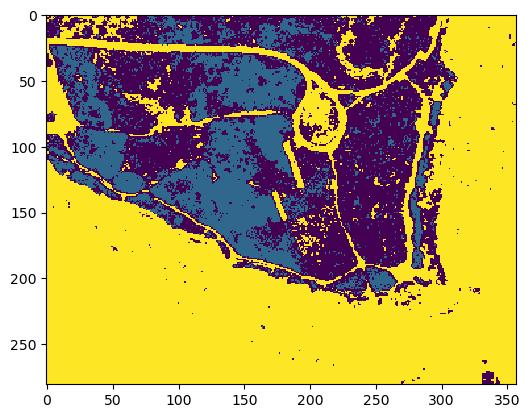

In [21]:
plt.imshow(images[3], interpolation='none')
plt.show()

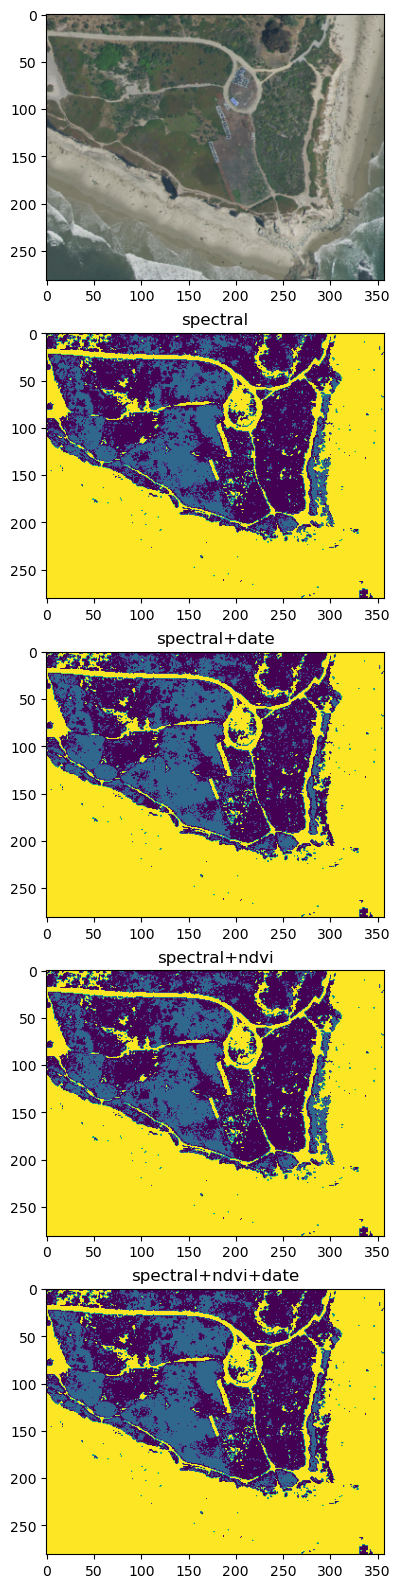

In [37]:
fig, ax = plt.subplots(5,1,figsize=(30, 20))

ax[0].imshow(np.moveaxis(rast1.loc[1:3].to_numpy(),0,-1))

for i, title in zip(range(1,5),feats):
    ax[i].imshow(images[i-1])
    ax[i].set_title(title)


plt.show()